## CySec data analytics Deep dive lab

In this lab, we'll continue from our analysis on the cysec data analytics lab. As you have seen in the previous lab, we only looked at accuracy of our models. There are many other performance metrics available for binary classification. We shall look at some of these in this lab.

## STEP 1: Import necessary libraries.

In [2]:
# Import necessary libraries
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.grid'] = False
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

## STEP 2: Load the dataset

In [3]:
link = "data/CySecData.csv"
# Load the dataset
df = pd.read_csv(link)
# # Display the first few rows of the dataset
# print(df.head())
# # Display the shape of the dataset
# print(df.shape)
# # Display the columns of the dataset
# print(df.columns)

## STEP 3: Load the pre-processed features (X), target (y) and models from previous lab

In [4]:
from sklearn.metrics import classification_report

X = pd.read_csv('data/Preprocessed_X.csv')
from sklearn.preprocessing import LabelEncoder

# Encode the 'class' column into numeric values
# label_encoder = LabelEncoder()
y = df['class']
print(y)
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('SVM', SVC()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

0         normal
1         normal
2        anomaly
3         normal
4         normal
          ...   
25187    anomaly
25188    anomaly
25189    anomaly
25190    anomaly
25191    anomaly
Name: class, Length: 25192, dtype: object


Answer the following questions based on the plots.
1. Which model seems to perform better than others?
2. Why do you think it performed better?
3. Please explain True positive, true negative, false positive and false negative values for binary classification in this context.

Enter you answer here and make sure to comment them out.

1.
2.
3.

## STEP 4: Visualize the model performance

In this step, you need to visualize the model performance by plotting the confusion matrix. Know more about it here: https://www.geeksforgeeks.org/confusion-matrix-machine-learning/. Please use StratifiedKFold this time instead of KFold. 

Hint: You should have figures like the following for each of the models

![alt text][def]

[def]: classification_report.png

In [5]:
# Use StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for name, model in models:
    # Perform cross-validation
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name}')
        
        # Calculate metrics
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
        recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Display metrics on the plot
        plt.text(1.05, -0.1, f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1_score:.4f}', 
                 ha='left', va='center', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        # Save the plot with model name and fold number
        plt.savefig(f'confusion_matrix_{name}_fold_{kfold.get_n_splits()}.png')
        plt.close()
        

## STEP 5: TPR and FPR analysis with Operating Characteristics Curve (AUC-ROC)
In this step, we'll plot True positive rate (TPR) and False positive rate (FPR). These two values are extremely important for almost any ML models. In this plot, the area under the curve represents the AUC-ROC. Know more about it here: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=The%20area%20under%20the%20ROC,curve%20(AUC)%20of%201.0.

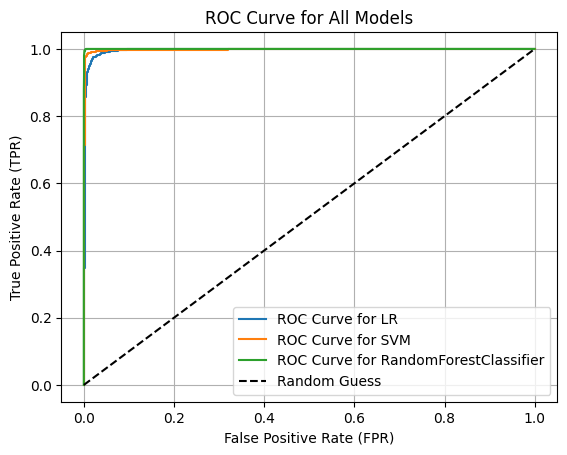

In [6]:
from sklearn.metrics import roc_curve, RocCurveDisplay


for name, model in models:
    # Compute FPR and TPR for the current model
    y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    tpr, fpr, _ = roc_curve(y_test, y_score, pos_label='anomaly')

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'ROC Curve for {name}')

# Add random guess line and labels
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for All Models')
plt.legend()
plt.grid()
plt.show()

## STEP 6: Check feature importance for Random Forest Classifier

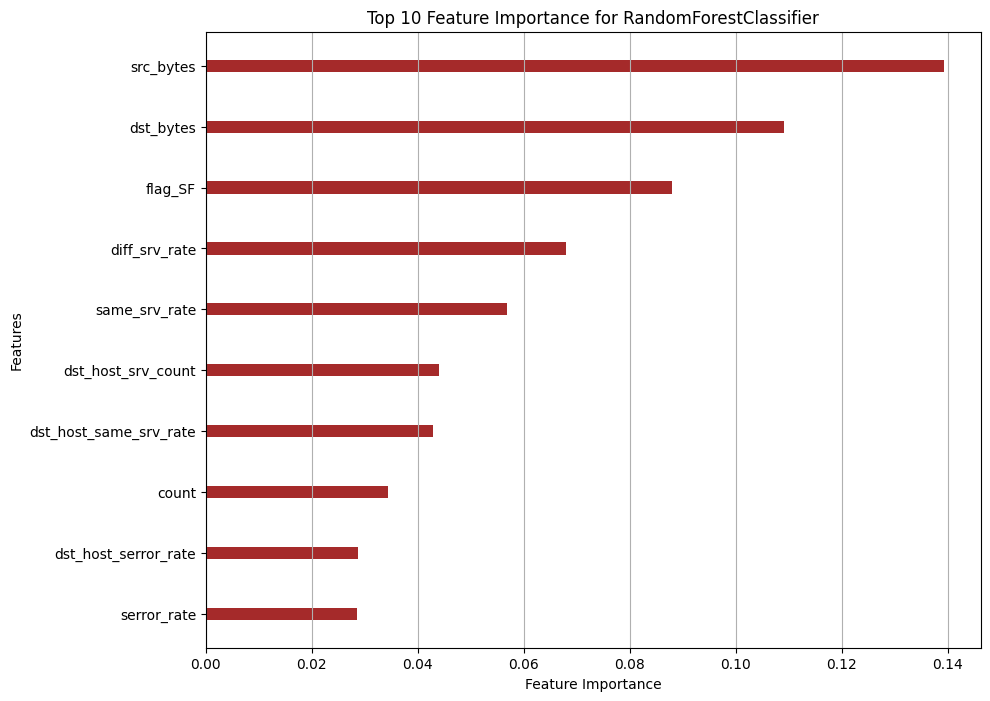

In [7]:
# Plot top 10 feature importance for tree-based models
for name, model in models:
    if hasattr(model, "feature_importances_"):
        # Get feature importances
        importances = model.feature_importances_
        feature_names = X.columns
        
        # Combine feature names and their importances
        feature_importance = list(zip(feature_names, importances))
        
        # Sort features by importance in descending order and select the top 10
        sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)[:10]
        top_feature_names, top_importances = zip(*sorted_features)

        # Create a bar plot
        plt.figure(figsize=(10, 8))
        plt.barh(top_feature_names, top_importances, color='brown', height=0.2)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Top 10 Feature Importance for {name}')
        plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
        plt.grid(axis='x')
        plt.show()

## STEP 7: Plot a Pareto chart
There are many ways to show feature importance. One of the most popular ones is Pareto chart. Show the pareto chart that contains the factors whose contributions sum up to 80%

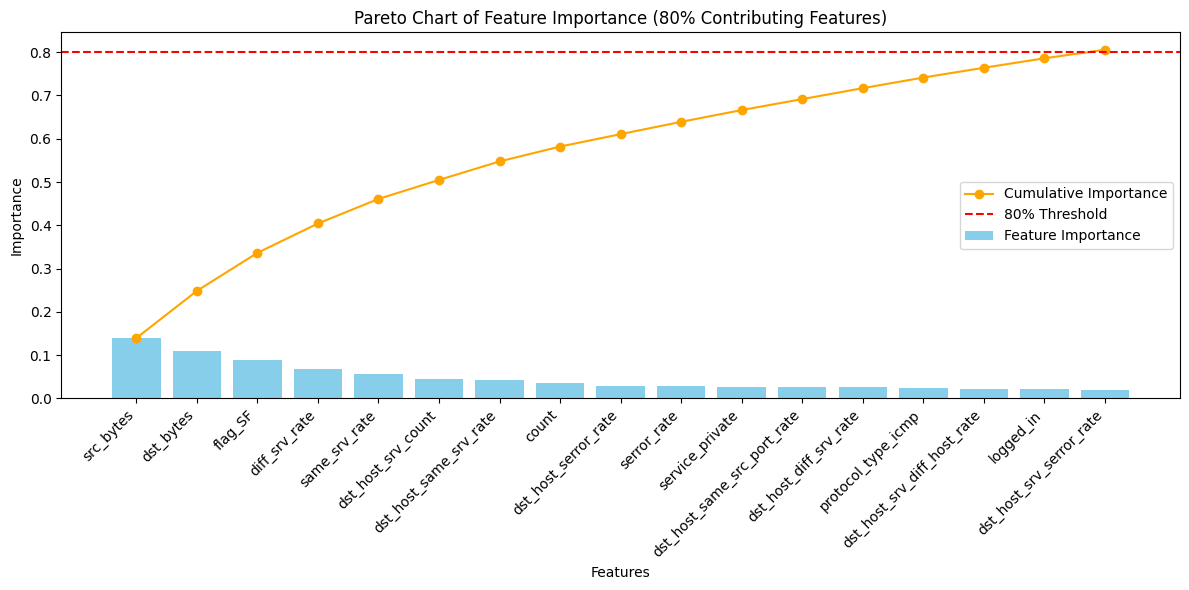

In [8]:
# Sort features by importance in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Calculate cumulative importance
cumulative_importance = np.cumsum([importance for _, importance in sorted_features])

# Find the index where cumulative importance reaches 80%
threshold_index = np.argmax(cumulative_importance >= 0.8)

# Select features contributing to 80% of the importance
pareto_features = sorted_features[:threshold_index + 1]
pareto_feature_names, pareto_importances = zip(*pareto_features)

# Plot Pareto chart
plt.figure(figsize=(12, 6))
plt.bar(pareto_feature_names, pareto_importances, color='skyblue', label='Feature Importance')
plt.plot(pareto_feature_names, cumulative_importance[:threshold_index + 1], color='orange', marker='o', label='Cumulative Importance')
plt.axhline(y=0.8, color='red', linestyle='--', label='80% Threshold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Pareto Chart of Feature Importance (80% Contributing Features)')
plt.legend()
plt.tight_layout()
plt.show()

## STEP 8: Refine the model
Use the selected features to refine the model.

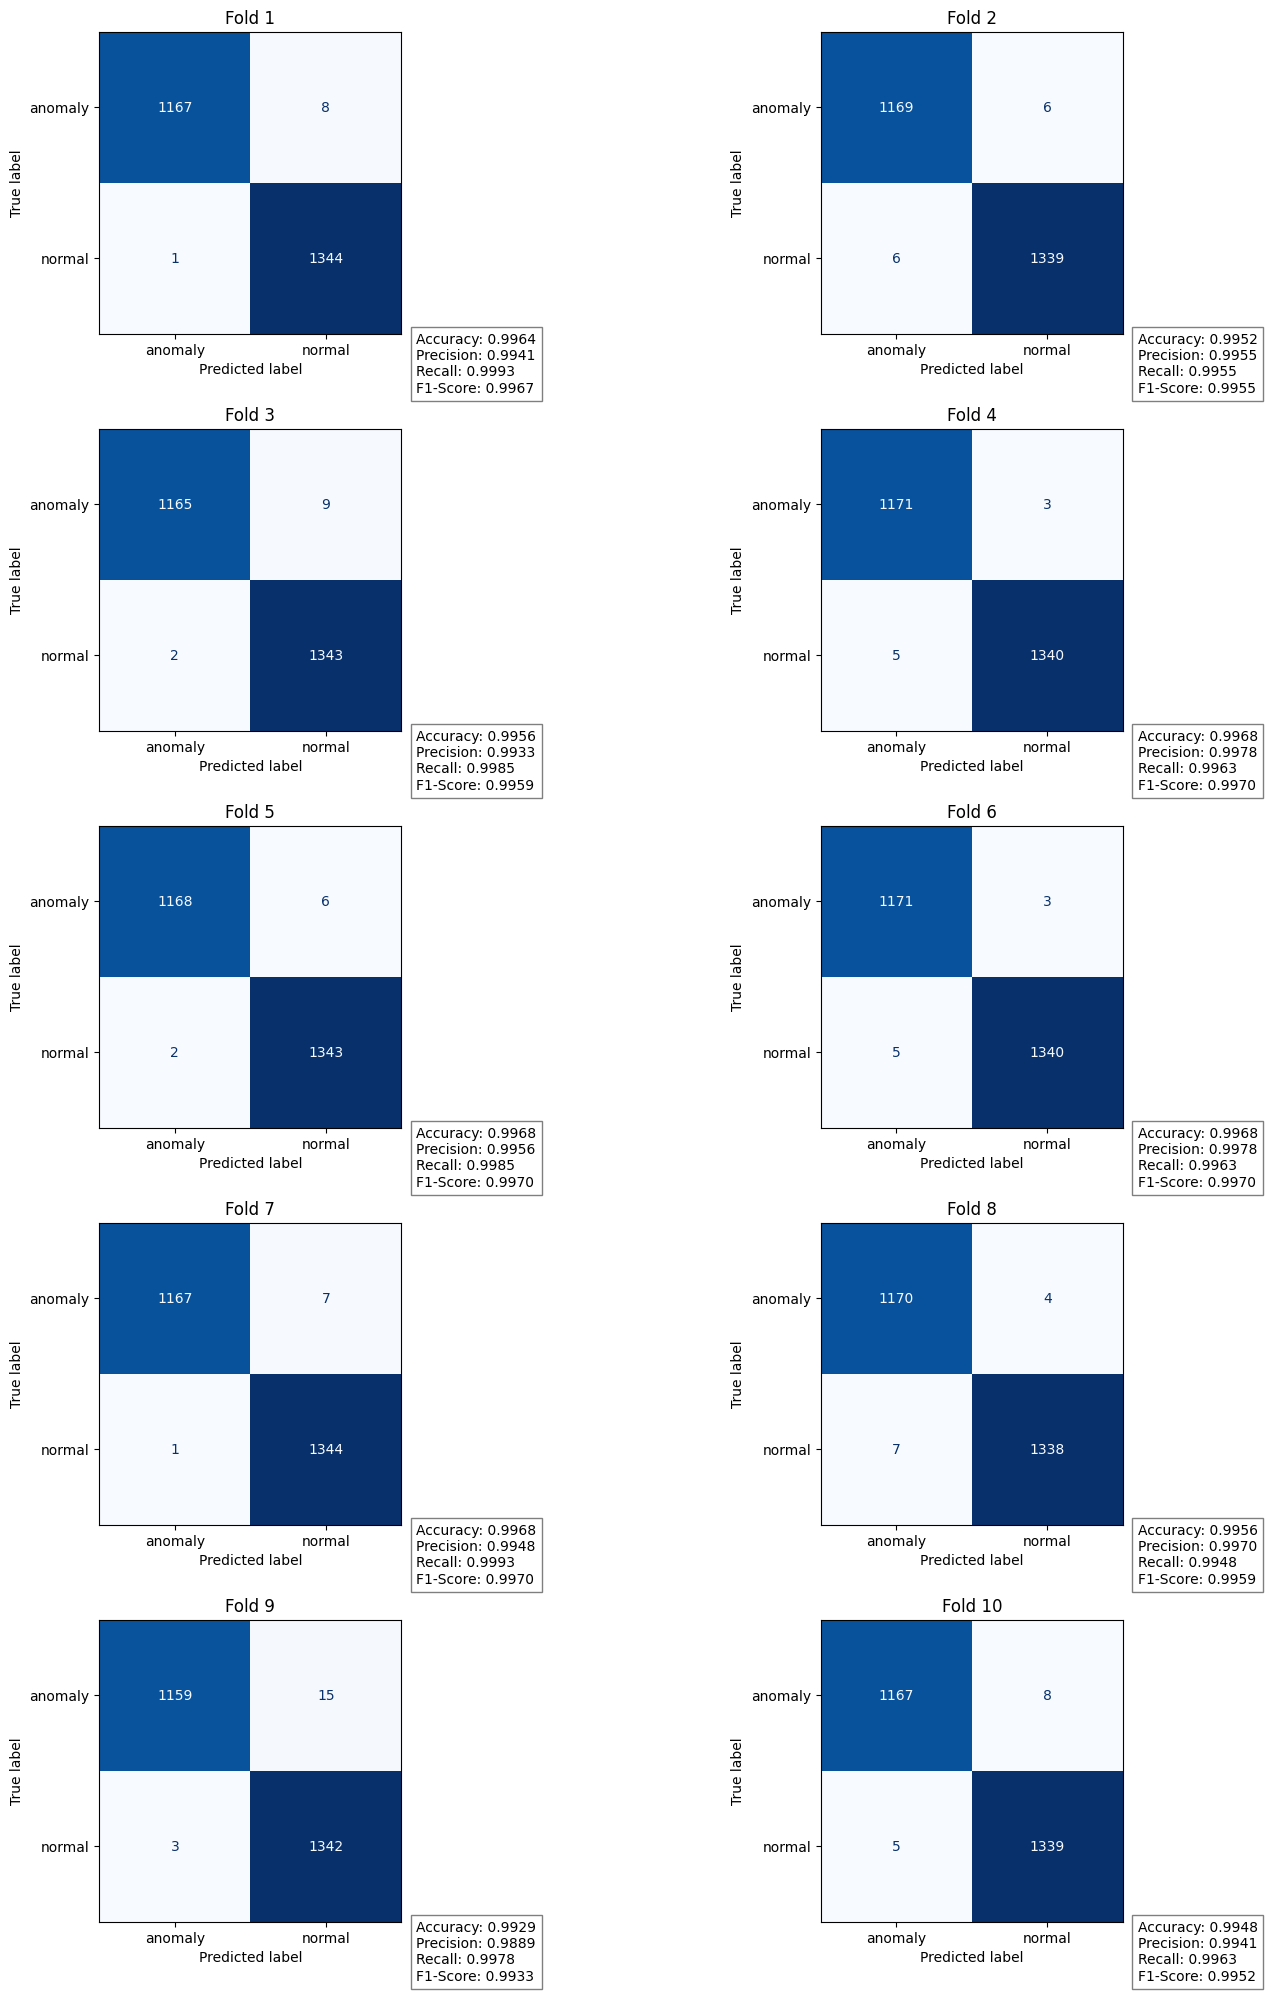

In [9]:
# Select only the top 10 features
n = 0
X_top_features = X[list(top_feature_names)]

# Use StratifiedKFold for cross-validation with the top 10 features
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
models = ['RandomForestClassifier', RandomForestClassifier()]

# Create a figure with 10 subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

# Perform cross-validation
for train_index, test_index in kfold.split(X_top_features, y):
    X_train, X_test = X_top_features.iloc[train_index], X_top_features.iloc[test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    
    # Plot confusion matrix in the corresponding subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=axes[n], colorbar=False)
    axes[n].set_title(f'Fold {n + 1}')
    
    # Calculate metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Display metrics on the subplot
    axes[n].text(1.05, -0.1, f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1_score:.4f}', 
                 ha='left', va='center', transform=axes[n].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.grid(False)
    n += 1

# Adjust layout
plt.tight_layout()
plt.show()

## STEP 9: Clustering analysis

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


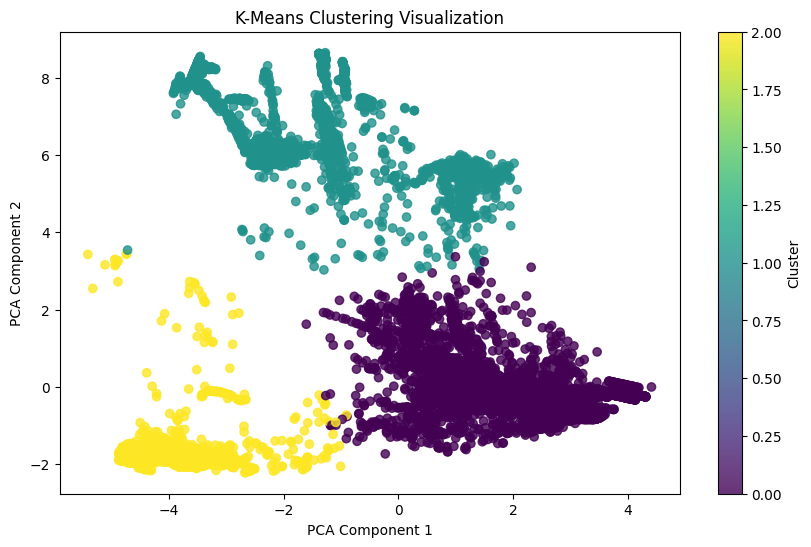

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
print(df.columns)
# Select numerical features for clustering
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Standardize the data
scaler = StandardScaler()
scaled_data = X

# Perform PCA for dimensionality reduction (optional, for visualization)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataframe
df['Cluster'] = clusters

# Visualize the clusters using PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', alpha=0.8)
plt.title('K-Means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

## STEP 10: Convert your notebook file to a script (.py)

In [11]:
!jupyter nbconvert --to script notebook.ipynb

[NbConvertApp] Converting notebook notebook.ipynb to script
[NbConvertApp] Writing 10560 bytes to notebook.py
